In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

node_data = pd.read_csv('rank.csv')
relation_data = pd.read_csv('rel.csv')

# 定义网格大小
grid_size = 700
grid_step = 1  # 每个网格的大小

# 初始化网格
grid_counts = np.zeros((grid_size // grid_step, grid_size // grid_step))

# 圆心与半径
center_x, center_y = 950, 500
radius = 301

# 将数据转换为相对于圆心的极坐标，并缩放到网格内
node_data['r'] = np.sqrt((node_data['x'] - center_x) ** 2 + (node_data['y'] - center_y) ** 2)
node_data['theta'] = np.arctan2(node_data['y'] - center_y, node_data['x'] - center_x)

# 筛选在圆内的点
node_data = node_data[node_data['r'] <= radius]

# 映射到网格坐标
node_data['grid_x'] = ((node_data['x'] - (center_x - radius)) / (2 * radius) * (grid_size - 1)).astype(int)
node_data['grid_y'] = ((node_data['y'] - (center_y - radius)) / (2 * radius) * (grid_size - 1)).astype(int)
node_dict = node_data.set_index('id')[['grid_x', 'grid_y']].to_dict(orient='index')


# 遍历所有的关系线条
for _, row in relation_data.iterrows():
    source_id = row['source']
    target_id = row['target']
    
    if source_id in node_dict and target_id in node_dict:
        # 获取线条的起点和终点的网格坐标
        x0, y0 = node_dict[source_id]['grid_x'], node_dict[source_id]['grid_y']
        x1, y1 = node_dict[target_id]['grid_x'], node_dict[target_id]['grid_y']
        
        # 使用Bresenham算法计算经过的网格
        dx = abs(x1 - x0)
        dy = abs(y1 - y0)
        sx = 1 if x0 < x1 else -1
        sy = 1 if y0 < y1 else -1
        err = dx - dy

        while True:
            grid_counts[y0 // grid_step, x0 // grid_step] += 1
            if x0 == x1 and y0 == y1:
                break
            e2 = 2 * err
            if e2 > -dy:
                err -= dy
                x0 += sx
            if e2 < dx:
                err += dx
                y0 += sy
                
grid_counts_int = grid_counts.astype(int)

# 将转换后的 grid_counts 写成文本保存
np.savetxt('grid-html/assets/grid_counts1.txt', grid_counts_int, fmt='%d')

In [64]:
node_data.to_csv('html/assets/node_data.csv', index=False)

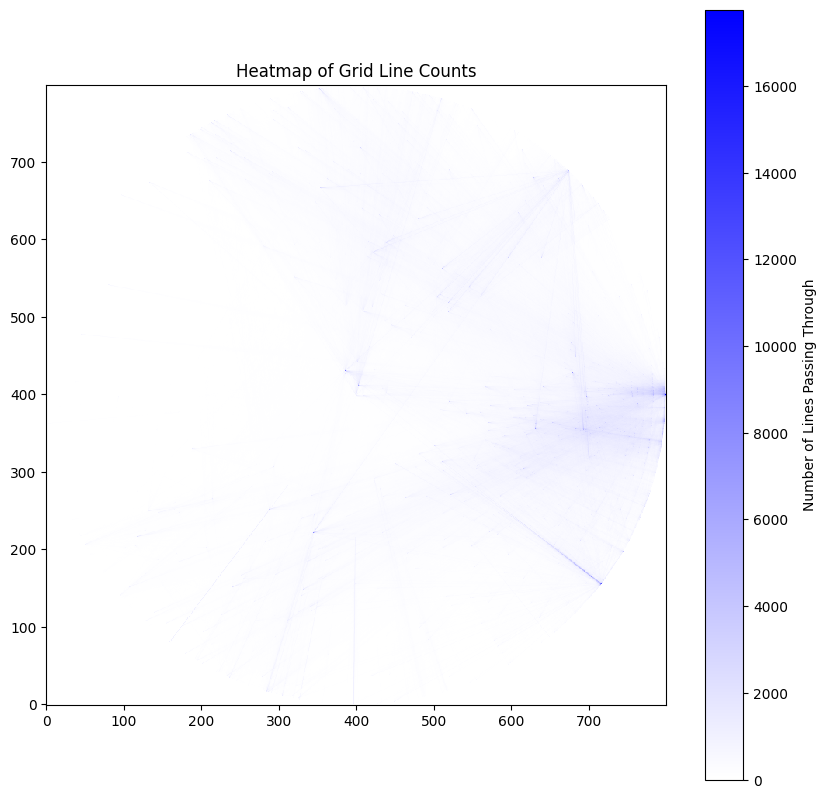

In [65]:
# 读取本地的 grid_counts 数据
grid_counts_int = np.loadtxt('grid_counts.txt', dtype=int)
# 自定义颜色映射：浅红色到深红色
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['white', 'blue'])
plt.figure(figsize=(10, 10), dpi=100)
# 绘制结果
plt.imshow(grid_counts_int, cmap=cmap, interpolation='nearest', origin='lower')
plt.colorbar(label='Number of Lines Passing Through')
plt.title('Heatmap of Grid Line Counts')
plt.show()

In [84]:
# 读取本地的 grid_counts 数据
grid_counts_int = np.loadtxt('html/assets/grid_counts.txt', dtype=int)

# 获取网格的大小
grid_size = grid_counts_int.shape[0]

# 圆心坐标
center_x, center_y = grid_size // 2, grid_size // 2

# 初始化归一化后的网格
normalized_grid_counts = np.zeros_like(grid_counts_int, dtype=float)

# 逐步扫描每个角度的方格并进行归一化
for angle in np.linspace(0, 2 * np.pi, 360):
    x_offset = np.cos(angle)
    y_offset = np.sin(angle)
    
    # 计算沿着该角度方向的方格列表
    radius_values = []
    radius_indices = []
    
    r = 0
    while True:
        x = int(center_x + r * x_offset)
        y = int(center_y + r * y_offset)
        
        if 0 <= x < grid_size and 0 <= y < grid_size:
            radius_values.append(grid_counts_int[y, x])
            radius_indices.append((y, x))
        else:
            break
        
        r += 1
    
    # 对这些方格的值进行归一化
    if len(radius_values) > 0:
        max_value = max(radius_values)
        if max_value > 0:
            normalized_values = [v / max_value for v in radius_values]
        else:
            normalized_values = [0] * len(radius_values)
        
        # 将归一化后的值填回到 normalized_grid_counts 中
        for (y, x), value in zip(radius_indices, normalized_values):
            normalized_grid_counts[y, x] = value


np.savetxt('html/assets/grid_counts_r.txt', normalized_grid_counts, fmt='%.6f')

In [89]:
# 读取本地的 grid_counts 数据
grid_counts_int = np.loadtxt('html/assets/grid_counts.txt', dtype=int)

# 对每一列进行归一化处理
# 归一化公式：(X - X_min) / (X_max - X_min)
grid_counts_normalized = np.zeros_like(grid_counts_int, dtype=float)
for j in range(grid_counts_int.shape[1]):
    col = grid_counts_int[:, j]
    min_val = np.min(col)
    max_val = np.max(col)
    if max_val - min_val != 0:  # 避免除以零的情况
        grid_counts_normalized[:, j] = (col - min_val) / (max_val - min_val)
    else:
        grid_counts_normalized[:, j] = col  # 如果最大值等于最小值，保持原值（或者设置为0）
grid_counts_normalized1 = grid_counts_normalized.astype(float)
# 将归一化结果保存到txt文件
np.savetxt('html/assets/grid_counts_normalized_col.txt', grid_counts_normalized1, fmt='%.10f')

In [90]:
# 对每一行进行归一化处理
# 归一化公式：(X - X_min) / (X_max - X_min)
grid_counts_normalized = np.zeros_like(grid_counts_int, dtype=float)
for i in range(grid_counts_int.shape[0]):
    row = grid_counts_int[i, :]
    min_val = np.min(row)
    max_val = np.max(row)
    if max_val - min_val != 0:  # 避免除以零的情况
        grid_counts_normalized[i, :] = (row - min_val) / (max_val - min_val)
    else:
        grid_counts_normalized[i, :] = row  # 如果最大值等于最小值，保持原值（或者设置为0）

# 将归一化结果保存到txt文件
np.savetxt('html/assets/grid_counts_normalized_row.txt', grid_counts_normalized, fmt='%.10f')